# Const. $B$-field model demo for 3D modeling


This notebook demonstrates the python code for the SSC model and fit of the constant $B$ field model for the Crab nebula based on Meyer et al. (2010). 

In [1]:
import sys
sys.path.append("/Users/manuelmeyer/Python/crabmeyerpy/")
sys.path.append("/Users/manuelmeyer/Python/fast_interp/")

In [2]:
from crabmeyerpy.ssc import kpc2cm, m_e_eV, arcmin2rad, eV2erg, eV2Hz, CrabSSC
from crabmeyerpy.ssc_3d import CrabSSC3D
from crabmeyerpy.electrondensity import nel_crab, nel_crab_extension
from crabmeyerpy.photonfields import black_body
from crabmeyerpy.data import CrabData
from scipy.integrate import simps, romb
import matplotlib.pyplot as plt
import numpy as np
import logging
import copy
import astropy.constants as c
import astropy.units as u
import time

In [3]:
%load_ext autoreload
%autoreload 2

# Load 1D model

For comparison purposes we initialize the 1D model.

In [4]:
# the config for the 1D model
config_1d = {
    # electron spectrum parameters
    "params_n_el": {
        "Nradio": np.exp(120.),
        "gradio_min": np.exp(3.1),
        "gradio_max": np.exp(12.1),
        "Sradio": -1.60,
        "Nwind": np.exp(78.6),
        "gmin": np.exp(3.1),
        "gmax": np.exp(30.),
        "gwind_min": np.exp(12.96),
        "gwind_max": np.exp(22.51),
        "gwind_b": 1. / np.exp(19.5),
        "Swind": -3.23,
        "Sbreak": -0.53, 
        "sup_wind": 2.8,
    },
    # seed photon field parameters
    "params_n_seed": {
        "dust_T": 97.6,
        "dust_norm": 1.06e-13 / 8.11e-06,  # for new dust function
        "dust_extension": 1.3,
        "ic_sync": True, 
        "ic_dust": True,
        "ic_cmb": True
    }
}

In [5]:
#The magnetic field strength and the distance to the nebula
B = 124e-6  # B Field in G
d = 2.  # distance to nebula in kpc

In [6]:
# intitialize the model
ssc_1d = CrabSSC(copy.deepcopy(config_1d), nel_crab, B=B, d=d)

In [7]:
# compute the sync, dust, and IC components
# synchtron and dust component
nu_s_1d = np.logspace(7.,25.,200)  # Frequency in Hz
F_nu_sync_1d = ssc_1d.sync(nu_s_1d)
F_nu_dust_1d = ssc_1d.grey_body(nu_s_1d)

# IC component
nu_ic_1d = np.logspace(20.,30.,100)  # Frequency in Hz
F_nu_IC_1d = ssc_1d.ic(nu_ic_1d, g_steps=100, e_steps=50)

/Users/manuelmeyer/Python/crabmeyerpy/crabmeyerpy/photonfields.py:22: RuntimeWarning: overflow encountered in exp
  result = np.exp(kx) - 1.


Text(0, 0.5, '$\\nu L_\\nu\\,(\\mathrm{erg}\\,\\mathrm{s}^{-1}$)')

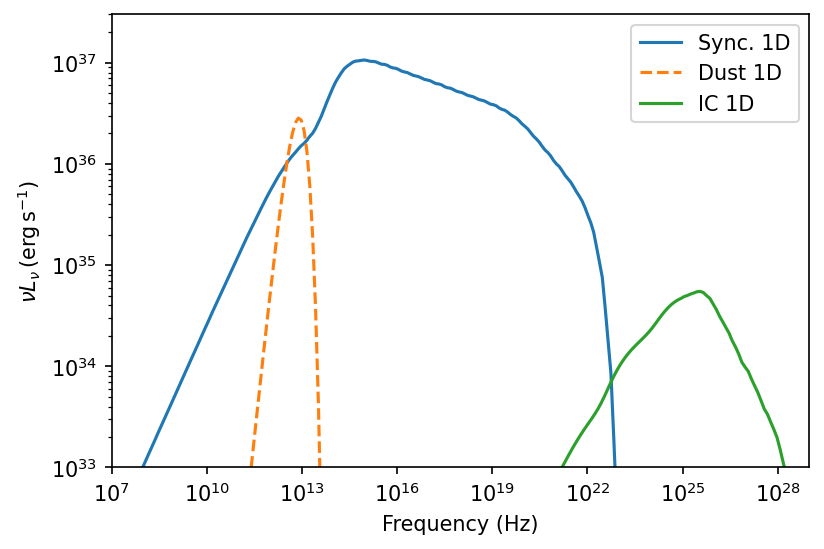

In [8]:
# plot function to plot 1d model output
def plot_1d(luminosity=True, ic=True, sync=True, dust=True, dpi=150, fig=None):
    if fig is None:
        plt.figure(dpi=dpi)
    if luminosity:
        c = 4. * np.pi * (d * kpc2cm)**2
    else:
        c = 1.

    if sync:
        plt.loglog(nu_s_1d, F_nu_sync_1d * nu_s_1d * c, ls='-', label="Sync. 1D")
    if dust:
        plt.loglog(nu_s_1d, F_nu_dust_1d * nu_s_1d * c, ls='--', label="Dust 1D")
    if ic:
        plt.loglog(nu_ic_1d, F_nu_IC_1d * nu_ic_1d * c, ls='-', label="IC 1D")

plot_1d()
plt.gca().set_ylim(1e33,3e37)
plt.gca().set_xlim(1e7,1e29)
plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu L_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}$)")

# 3D model

Next we initialize the 3D model

In [9]:
# config to match 1D case
config = {
    # electron spectrum parameters
    "Nradio": np.exp(-9.5) * 1.3, # these are just some scalings
    "gradio_min": np.exp(3.1),
    "gradio_max": np.exp(12.1),
    "Sradio": -1.60,
    "Nwind": np.exp(-48.) * 2, # these are just some scalings
    "gmin": np.exp(3.1),
    "gmax": np.exp(30.),
    "gwind_min": np.exp(13.1),
    "gwind_max": np.exp(22.6),
    "gwind_b": 1. / np.exp(19.5),
    "Swind": -2.85,
    "Sbreak": -0.6, 
    "sup_wind": 2.8,
    # spatial parameters, this is new
    "gamma_br_const": 34e9 / m_e_eV, # below this gamma value, the nebula has constant size, in Hillas et al: 34. GeV
    "radio_size_cm": np.tan(1.35 * arcmin2rad) * d * kpc2cm,  # constant size of Gaussian below gamma_br_constant in arcmin 
    "index": -0.17,  # power-law index of energy dependency
    "amplitude": np.tan(1.2 * arcmin2rad) * d  * kpc2cm,  # amplitude for PL spatial dependence
    "offset": np.tan(0.15 * arcmin2rad) * d * kpc2cm,  # offset for high energies
    "dust_T": 97.6,
    "dust_norm": 1.0e-11  / (0.001 * kpc2cm)**3 / 4. / np.pi,  # for new dust function
    "dust_extension": 1.3,  # extension of nebula in FIR from dust
    "ic_sync": True, 
    "ic_dust": True,
    "ic_cmb": True,
    "B": B
}

In [10]:
print("Break energy of wind spectrum {0:e}eV".format(1. / config['gwind_b'] * m_e_eV))

Break energy of wind spectrum 1.503704e+14eV


In [11]:
# maximum radius of nebula
# This number should probably be updated to newer values
# it comes from Atoyan & Aharonian 1996
r0_pc = 1.8

In [12]:
# the assumed electron spectrum
def n_el_spec(gamma, r, **params):
    return nel_crab(gamma, **params) * nel_crab_extension(r, gamma, **params)

# the assumed radial dependence of the magnetic field
def const_B(r, **params):
    result = np.full(r.shape, params['B'])
    return result

Initialize the model

In [13]:
ssc = CrabSSC3D(copy.deepcopy(config), n_el_spec, const_B, d_kpc=d, r0_pc=r0_pc, log_level="DEBUG", 
                ic_sync=True, ic_cmb=True, ic_dust=True)

Set the dust parameters

In [14]:
# It's also possible to use a shell/constant like in Atoyan & Aharonian 1996
ssc.parameters['dust_extension'] = np.tan(ssc.r0 / ssc.d) / arcmin2rad


# set it to constant
ssc.dust_radial_dependence = 'shell'
# this is the inner radius of the shell:
ssc.parameters['min_dust_extension'] = 0.

# decrease dust norm
ssc.parameters['dust_norm'] = 5e-12

# but for now, let's use the same 
# parameters as in the 1D model
# where the dust was modeled as a 
# Gaussian
ssc.parameters['dust_extension'] = 1.3
ssc.dust_radial_dependence = 'gauss'
ssc.parameters['dust_norm'] = 1.0e-11  / (0.001 * kpc2cm)**3 / 4. / np.pi

print("Dust extension: {0:.2f} arcmin".format(ssc.parameters['dust_extension']))

Dust extension: 1.30 arcmin


## plot the electron density at different radii

In [15]:
r = np.linspace(0., ssc.r0, 9)
gamma = np.logspace(0., 10., 100)

gg, rr = np.meshgrid(gamma, r, indexing='ij')

Text(0, 0.5, '$ mc^2 \\gamma^2 dn/d\\gamma $ (eV cm$^{-3}$)')

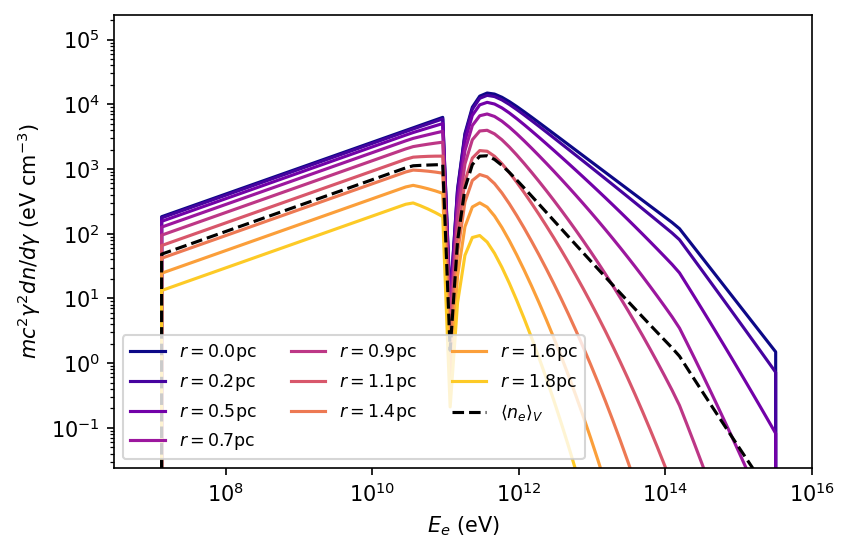

In [16]:
plt.figure(dpi=150)

c = gamma**2. * m_e_eV

# compute n_el over grid of gamma and r
n_el = ssc.n_el(gg, rr, **ssc.parameters)

# compute volume averaged n_el
V0 = 4. / 3. * np.pi * ssc.r0 ** 3.
n_el_avg = 4. * np.pi * simps(n_el * rr ** 2., rr) / V0

for i, ri in enumerate(r):
    plt.loglog(gamma * m_e_eV, n_el[:,i] * c,
               color=plt.cm.plasma(i/r.size),
               label='$r={0:.1f}$pc'.format(ri / kpc2cm * 1e3)
              )
    
plt.loglog(gamma * m_e_eV, n_el_avg * c, ls='--', color='k',  label=r'$\langle n_e \rangle_V$')
plt.legend(fontsize='small', ncol=3)
v = plt.gca().get_ylim()
plt.ylim(v[1]/1e7, v[1])
plt.xlim(3.e6,1e16)
plt.xlabel("$E_e$ (eV)")
plt.ylabel("$ mc^2 \gamma^2 dn/d\gamma $ (eV cm$^{-3}$)")

## Calculate the Synchrotron and Dust emissivities

Cacluate the volume emissivity $j_\nu^\mathrm{sync}(\nu, r)$ in units of $\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-3}\,\mathrm{sr}^{-1}$.
From it, you can calculate the the luminosity as a volume integral, as well as the specific intensity as a l.o.s. integral. 
From the specific intensity, you get the flux by integrating over solid angle.

In [17]:
nu = nu_s_1d
nn, rr = np.meshgrid(nu, r, indexing='ij')

In [18]:
j_nu_sync = ssc.j_sync(nu, r, g_axis=2, g_steps=257, integration_mode='romb')
print(j_nu_sync.shape)

(200, 9)


Cacluate the volume emissivity $j_\nu^\mathrm{dust}(\nu, r)$ in units of $\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-3}\,\mathrm{sr}^{-1}$

In [19]:
j_nu_dust = ssc.j_grey_body(nu, r)
print(j_nu_dust.shape)

/Users/manuelmeyer/Python/crabmeyerpy/crabmeyerpy/photonfields.py:22: RuntimeWarning: overflow encountered in exp
  result = np.exp(kx) - 1.
 ssc_3d.py: 513 --- DEBUG: Black body calculation in grey body function took 0.000s
 ssc_3d.py: 547 --- DEBUG: extension calculation in grey body function took 0.000s


(200, 9)


Plot the volume emissivity

(1e-25, 1e-18)

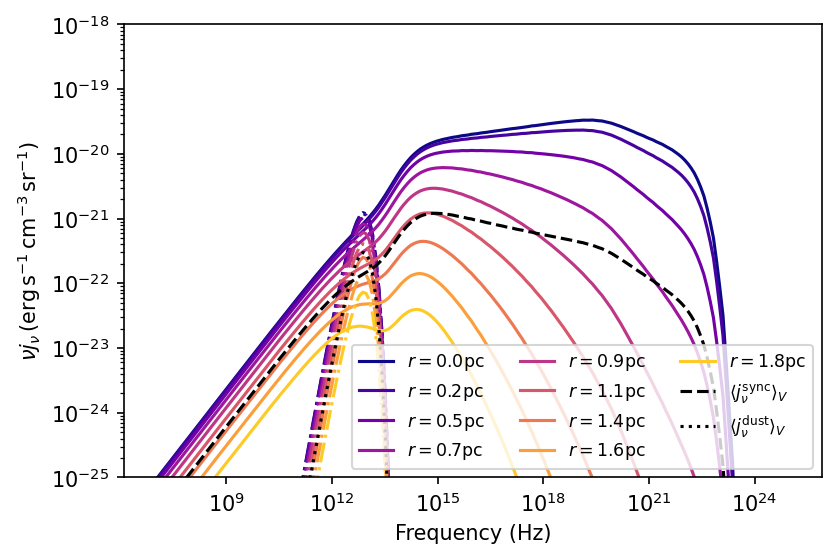

In [20]:
plt.figure(dpi=150)

for i, ri in enumerate(r):
    plt.loglog(nu, j_nu_sync[:,i] * nu,
               color=plt.cm.plasma(i/r.size),
               label='$r={0:.1f}$pc'.format(ri / kpc2cm * 1e3)
              )
    plt.loglog(nu, j_nu_dust[:,i] * nu,
               color=plt.cm.plasma(i/r.size),
               ls='-.'
              )
    
# compute volume averaged n_el
V0 = 4. / 3. * np.pi * ssc.r0 ** 3.
j_nu_sync_avg = 4. * np.pi * simps(j_nu_sync * rr ** 2., rr) / V0
j_nu_dust_avg = 4. * np.pi * simps(j_nu_dust * rr ** 2., rr) / V0

plt.loglog(nu, j_nu_sync_avg * nu,
           color='k',
           ls='--',
           label=r'$\langle j_\nu^\mathrm{sync} \rangle_V$'
           )

plt.loglog(nu, j_nu_dust_avg * nu,
           color='k',
           ls=':',
           label=r'$\langle j_\nu^\mathrm{dust} \rangle_V$'
           )

plt.legend(fontsize='small', ncol=3)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu j_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-3}\,\mathrm{sr}^{-1}$)")
plt.ylim(1e-25, 1e-18)

Calculate and plot the luminosity

In [21]:
# one factor of 4 pi from volume integral, second one from integral over 
# the solid angle. Each volume element emits isotropically.
L_nu_sync = romb(j_nu_sync * rr **2., dx=np.diff(r)[0], axis=1) * 4. * np.pi * 4. * np.pi
L_nu_dust = romb(j_nu_dust * rr **2., dx=np.diff(r)[0], axis=1) * 4. * np.pi * 4. * np.pi

(1e+33, 1e+38)

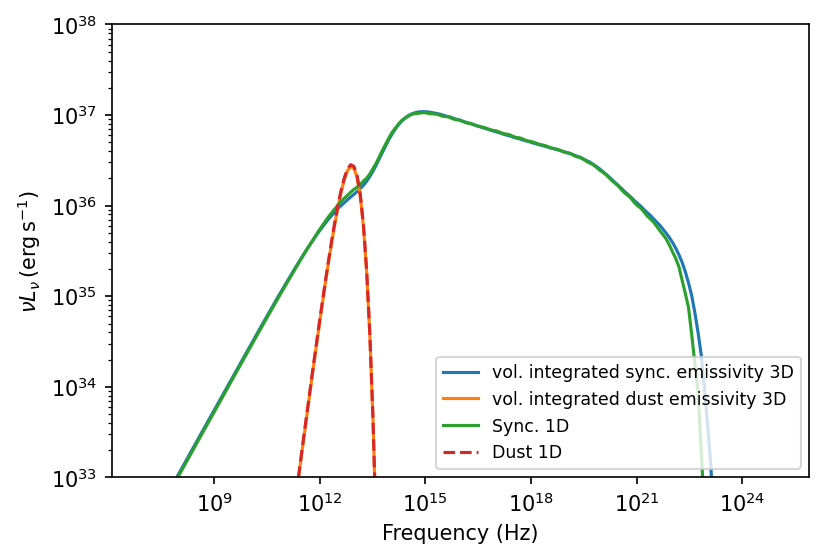

In [22]:
fig = plt.figure(dpi=150)
plt.loglog(nu, nu * L_nu_sync, label="vol. integrated sync. emissivity 3D")
plt.loglog(nu, nu * L_nu_dust, label="vol. integrated dust emissivity 3D")

# plot the 1D spectrum for comparison
plot_1d(fig=fig, ic=False)
plt.legend(fontsize='small')
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu L_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}$)")
plt.ylim(1e33, 1e38)

### Calculate the spectral intensity and flux

From radiation transport and neglecting absorption, the spectral intensity is given by the integral

$$ I_\nu(\theta) = \int_0^{s_\max} j_\nu(s) ds, $$ 

which depends on $\theta$, the angular separation between the nebula center and the line of sight.
To compute it efficiently, we first interpolate the synchrotron volume emissivity.

#### Flux calculation

Once we have obtained $ I_\nu(\theta) $, we can calulate the flux $F_\nu$ that is emitted into a solid angle $\Omega$ 
from a point on the surface of the nebula. This follows the standard calculation of, e.g., calculating the received flux from a resolved stellar disk, i.e., the flux emitted into $[0, \theta]$ is

$$F_\nu = \int I_\nu \cos\theta d\Omega = 2\pi\int_0^\theta I_\nu\cos\theta'\sin\theta' d\theta' $$

In [23]:
ssc.use_fast_interp = False  # use a 2D interpolation routine using numba

In [24]:
I_nu_sync, theta_arcmin, _ = ssc.intensity2(nu, theta=20, integration_mode='romb', r_steps=129)

In [25]:
I_nu_dust, _, _ = ssc.intensity2(nu, theta=20, which='dust', integration_mode='romb', r_steps=129)

/Users/manuelmeyer/Python/crabmeyerpy/crabmeyerpy/photonfields.py:22: RuntimeWarning: overflow encountered in exp
  result = np.exp(kx) - 1.
 ssc_3d.py: 513 --- DEBUG: Black body calculation in grey body function took 0.004s
 ssc_3d.py: 547 --- DEBUG: extension calculation in grey body function took 0.004s


Text(0, 0.5, '$\\nu I_\\nu\\,(\\mathrm{erg}\\,\\mathrm{s}^{-1}\\,\\mathrm{cm}^{-2}\\,\\mathrm{sr}^{-1}$)')

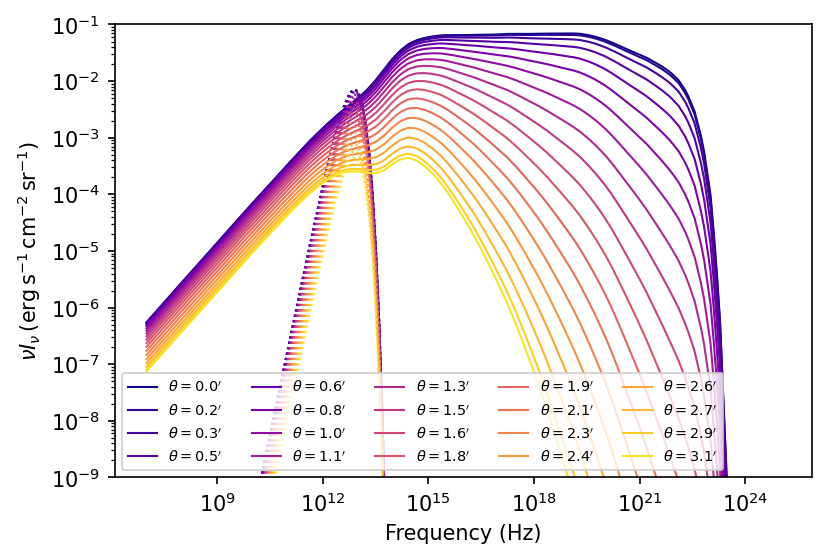

In [26]:
plt.figure(dpi=150)

for i, t in enumerate(theta_arcmin):
    plt.loglog(nu, I_nu_sync[:,i] * nu,
               color=plt.cm.plasma(i / float(theta_arcmin.size)),
               label=r"$\theta={0:.1f}^\prime$".format(t),
               lw=1
              )
    
    plt.loglog(nu, I_nu_dust[:,i] * nu,
               color=plt.cm.plasma(i / float(theta_arcmin.size)),
               #label=r"$\theta={0:.1f}^\prime$".format(t)
               ls=':', lw=1
              )
    
plt.legend(ncol=5, fontsize='x-small')
plt.ylim(1e-9, 1e-1)

plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu I_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{sr}^{-1}$)")

Text(0, 0.5, '$I_\\nu / I_\\nu(\\theta = 0^\\circ)$')

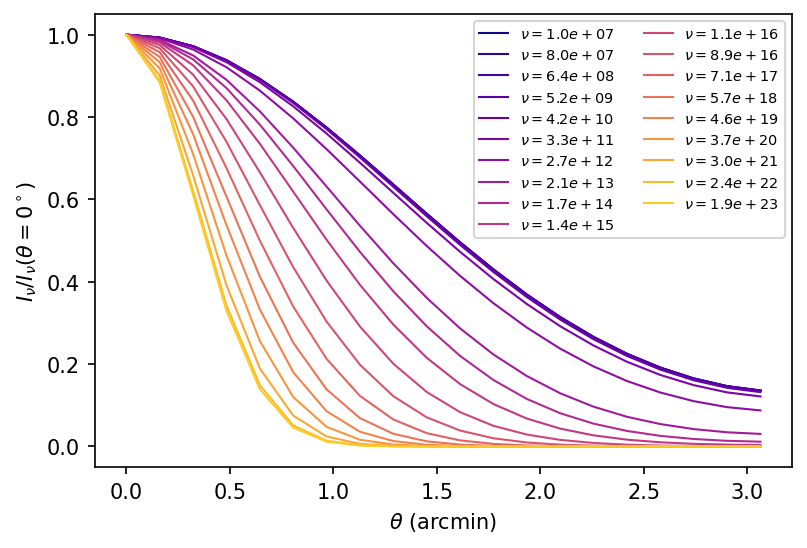

In [27]:
# intensity form factor for different frequencies

plt.figure(dpi=150)
for i, n in enumerate(nu[:-10]):
    if i % 10:
        continue
        
    plt.plot(theta_arcmin, I_nu_sync[i, :] / I_nu_sync[i, 0],
               color=plt.cm.plasma(i / float(nu.size)),
               label=r"$\nu={0:.1e}$".format(n),
               lw=1
            )
    
plt.legend(ncol=2, fontsize='x-small')
plt.xlabel(r"$\theta$ (arcmin)")
plt.ylabel(r"$I_\nu / I_\nu(\theta = 0^\circ)$")

/Users/manuelmeyer/Python/crabmeyerpy/crabmeyerpy/photonfields.py:22: RuntimeWarning: overflow encountered in exp
  result = np.exp(kx) - 1.
 ssc_3d.py: 513 --- DEBUG: Black body calculation in grey body function took 0.003s
 ssc_3d.py: 547 --- DEBUG: extension calculation in grey body function took 0.003s


Text(0, 0.5, '$\\nu F_\\nu\\,(\\mathrm{erg}\\,\\mathrm{s}^{-1}\\,\\mathrm{cm}^{-2}$)')

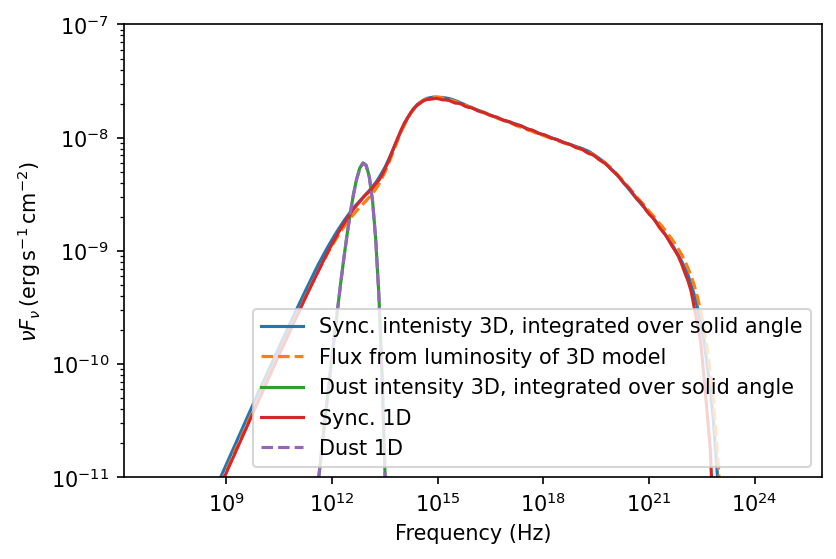

In [28]:
# plot and calculate the flux received from the whole projection of the nebula on the sky
fig=plt.figure(dpi=150)

nn, tt = np.meshgrid(nu, theta_arcmin, indexing='ij')

# synchrotron flux
# difference is roughly a factor of two, which makes sense as we're only considering 
# the flux in one direction towards us, right?
f_nu_sync = ssc.flux(nu, theta_edges=[theta_arcmin[0], theta_arcmin[-1]],
                     which='sync',
                     integration_mode='romb',
                     theta_steps=33)

# dust flux
# additional factor of 2 due to +/- theta extension of nebula disk
f_nu_dust = ssc.flux(nu, theta_edges=[theta_arcmin[0], theta_arcmin[-1]], which='dust')


plt.loglog(nu, f_nu_sync * nu, label="Sync. intenisty 3D, integrated over solid angle")

plt.loglog(nu, nu * L_nu_sync / 4. / np.pi / ssc.d ** 2.,
           ls="--", 
           label="Flux from luminosity of 3D model"
          )

plt.loglog(nu, f_nu_dust * nu, label="Dust intensity 3D, integrated over solid angle")
plt.ylim(1e-11, 1e-7)

# plot the 1D spectrum for comparison
plot_1d(luminosity=False, fig=fig, ic=False)

plt.legend()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu F_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}$)")

## IC component

Now we repeat the steps of calculating $j_\nu$, $I_\nu$, and $F_\nu$ for the IC component. 

In [29]:
# define nu and r arrays 
nu_ic = np.logspace(21., 31., 61)
r_ic_egdes = np.linspace(0., ssc.r0, 33)
r_ic = 0.5 * (r_ic_egdes[1:] + r_ic_egdes[:-1])

nni, rri = np.meshgrid(nu_ic, r_ic, indexing='ij')

# set the steps used for the integration
# these numbers yielded relatively smooth spectra
# in my tests 
# the r1_steps needs to be of the shape 2**k + 1 since romb integration is used
g_steps = 129  # steps for integration over gamma
e_steps = 129  # steps for integration over energy of seed photon field
r1_steps = 65   # steps for integration over radius, see Atoyan & Aharonian (1996) Eq. 15

In [30]:
ssc.integration_mode = "numba_piecewise"  # fastest mode of integration
ssc.use_fast_interp = True  # fastest mode of interpolation; also used to interpolate the photon densities

ssc.ic_sync = True
ssc.ic_dust = True
ssc.ic_cmb = True


t0 = time.time()
j_nu_ic = ssc.j_ic(nu_ic, r_ic,
                   g_steps=g_steps,
                   e_steps=e_steps,
                   r1_steps=r1_steps, 
                   integration_mode='romb'
                  )
t1 = time.time()

print(f"This took {t1 - t0:.2f}s")

 ssc_3d.py: 637 --- DEBUG: (129, 32, 65)
 ssc_3d.py: 638 --- DEBUG: Integrating using numba_piecewise
 ssc_3d.py: 646 --- DEBUG: phot_dens: time for interpolation of Sync: 0.014s, time for integration of SSC component  0.008s,  time for filling arrays 0.002s 
 ssc_3d.py: 513 --- DEBUG: Black body calculation in grey body function took 0.002s
 ssc_3d.py: 547 --- DEBUG: extension calculation in grey body function took 0.001s
 ssc_3d.py: 688 --- DEBUG: time to calculate grey body 0.006s  time for integration of dust component  0.004s
/Users/manuelmeyer/Python/miniforge3/envs/basic/lib/python3.9/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'a' of function '_interp2d_k1'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../fast_interp/fast_interp/fast

This took 4.14s


(1e-27, 1e-22)

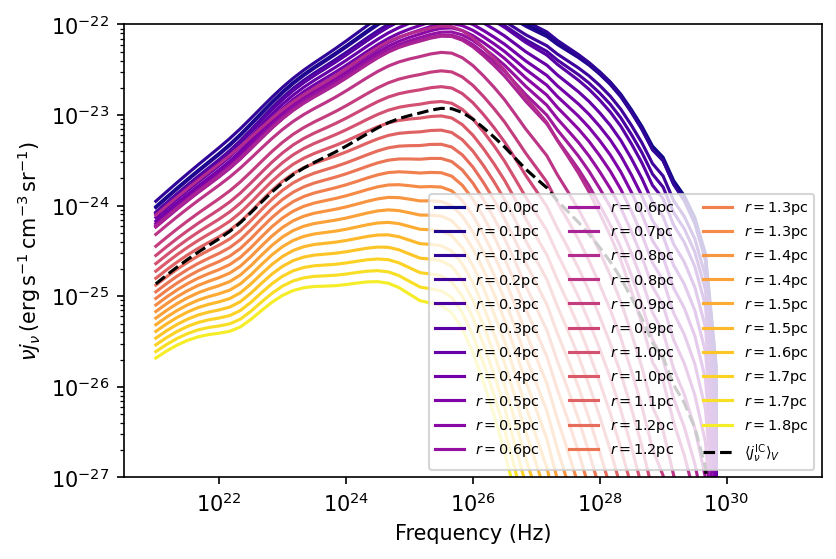

In [31]:
plt.figure(dpi=150)

for i, ri in enumerate(r_ic):
    plt.loglog(nu_ic, j_nu_ic[:,i] * nu_ic,
               color=plt.cm.plasma(i/r_ic.size),
               label='$r={0:.1f}$pc'.format(ri / kpc2cm * 1e3)
              )
    
# compute volume averaged n_el
V0 = 4. / 3. * np.pi * ssc.r0 ** 3.
j_nu_ic_avg = 4. * np.pi * simps(j_nu_ic * rri ** 2. * rri, np.log(rri)) / V0

plt.loglog(nu_ic, j_nu_ic_avg * nu_ic,
           color='k',
           ls='--',
           label=r'$\langle j_\nu^\mathrm{IC} \rangle_V$'
           )

plt.legend(fontsize='x-small', ncol=3)
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu j_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-3}\,\mathrm{sr}^{-1}$)")
plt.ylim(1e-27, 1e-22)

In [32]:
# Calculate the luminosity
# one factor of 4 pi from volume integral, second one from integral over 
# the solid angle. Each volume element emits isotropically.
L_nu_ic = simps(j_nu_ic * rri **2., rri, axis=1) * 4. * np.pi * 4. * np.pi

(1e+30, 3e+35)

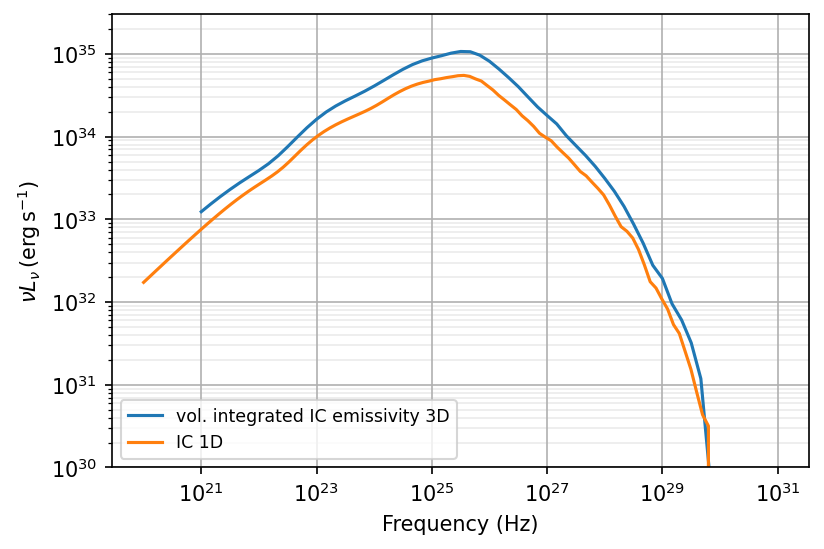

In [33]:
fig = plt.figure(dpi=150)
plt.loglog(nu_ic, nu_ic * L_nu_ic, label="vol. integrated IC emissivity 3D")

# plot the 1D spectrum for comparison
plot_1d(fig=fig, ic=True, sync=False, dust=False)
plt.legend(fontsize='small')
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu L_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}$)")
plt.grid()
plt.grid(which='minor', lw=0.2)
plt.ylim(1e30, 3e35)


In [34]:
I_nu_ic, theta_arcmin_ic, _ = ssc.intensity2(nu_ic, theta=30, which='ic', integration_mode='romb', r_steps=129)

Text(0, 0.5, '$\\nu I_\\nu\\,(\\mathrm{erg}\\,\\mathrm{s}^{-1}\\,\\mathrm{cm}^{-2}\\,\\mathrm{sr}^{-1}$)')

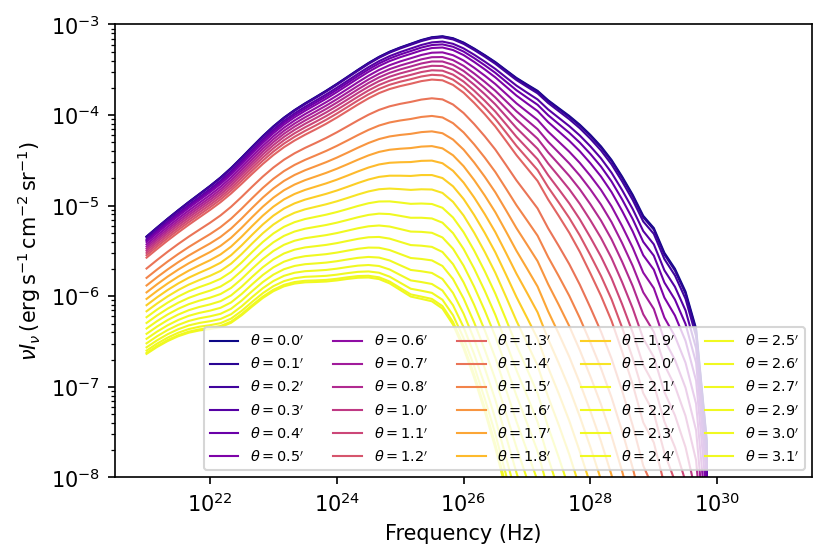

In [35]:
plt.figure(dpi=150)

for i, t in enumerate(theta_arcmin_ic):
    plt.loglog(nu_ic, I_nu_ic[:,i] * nu_ic,
               color=plt.cm.plasma(i / float(theta_arcmin.size)),
               label=r"$\theta={0:.1f}^\prime$".format(t),
               lw=1
              )

    
plt.legend(ncol=5, fontsize='x-small')
plt.ylim(1e-8, 1e-3)

plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu I_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}\,\mathrm{cm}^{-2}\,\mathrm{sr}^{-1}$)")

Text(0, 0.5, '$I_\\nu / I_\\nu(\\theta = 0^\\circ)$')

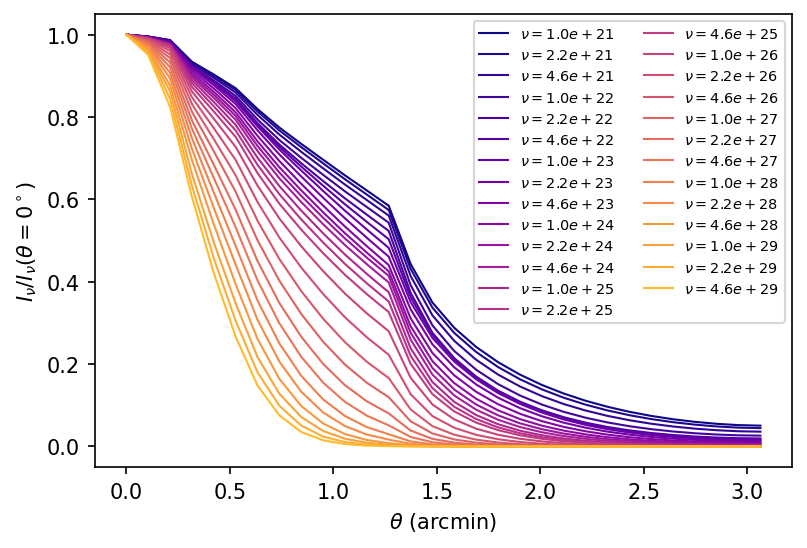

In [36]:
# intensity form factor for different frequencies

plt.figure(dpi=150)
for i, n in enumerate(nu_ic[:-7]):
    if i % 2:
        continue
        
    plt.plot(theta_arcmin_ic, I_nu_ic[i, :] / I_nu_ic[i, 0],
               color=plt.cm.plasma(i / float(nu_ic.size)),
               label=r"$\nu={0:.1e}$".format(n),
               lw=1
            )
    
plt.legend(ncol=2, fontsize='x-small')
plt.xlabel(r"$\theta$ (arcmin)")
plt.ylabel(r"$I_\nu / I_\nu(\theta = 0^\circ)$")

In [37]:
f_nu_ic = ssc.flux(nu_ic, theta_edges=[theta_arcmin[0], theta_arcmin[-1]],
                   which='ic',
                   integration_mode='romb',
                   r_steps=65,
                   theta_steps=65)

(1e-13, 3e-10)

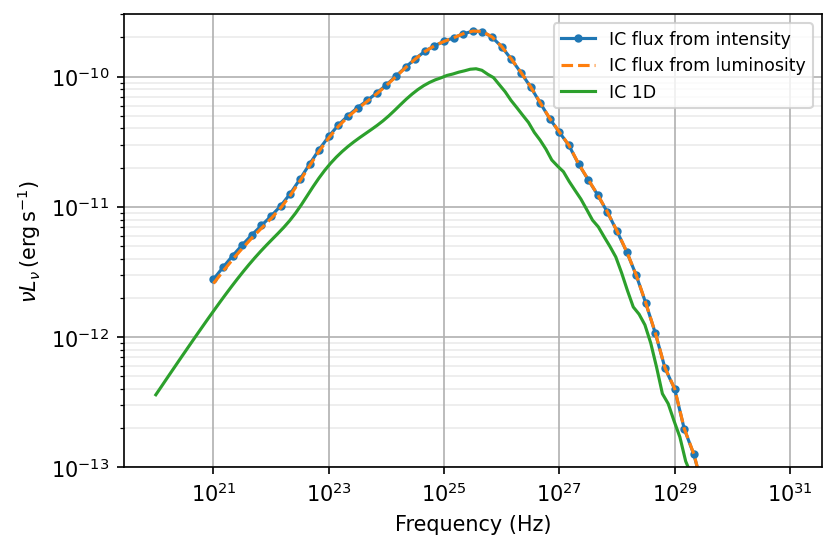

In [38]:
fig = plt.figure(dpi=150)
plt.loglog(nu_ic, nu_ic * f_nu_ic, label="IC flux from intensity", marker='.')

plt.loglog(nu_ic, nu_ic * L_nu_ic / 4. / np.pi / ssc.d ** 2.,
           label="IC flux from luminosity", ls='--')
# plot the 1D spectrum for comparison
plot_1d(fig=fig, ic=True, sync=False, dust=False, luminosity=False)
plt.legend(fontsize='small')
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\nu L_\nu\,(\mathrm{erg}\,\mathrm{s}^{-1}$)")
plt.grid()
plt.grid(which='minor', lw=0.2)
plt.ylim(1e-13, 3e-10)


## Full SED pass

Here, we time how long it takes to calculate the whole SED for one set of parameters.

In [39]:
%%timeit

# define r and nu arrays
r = np.linspace(0., ssc.r0, 10)
nu_sync = np.logspace(7.,25.,200)

# Calculate and interpolate the synchrotron spectrum
ssc.use_fast_interp = True  # use a 2D interpolation routine using numba
ssc.interp_sync_init(r_min=r.min(), r_max=r.max())

# Calculate the intensities along the line of sight
I_nu_sync, theta_arcmin, _ = ssc.intensity2(nu, theta=20)
I_nu_dust, _, _ = ssc.intensity2(nu, theta=20, which='dust')

# Calculate the IC emissivity
nu_ic = np.logspace(21., 31., 32)
r_ic_egdes = np.linspace(0., ssc.r0, 33)
r_ic = 0.5 * (r_ic_egdes[1:] + r_ic_egdes[:-1])

g_steps = 129  # steps for integration over gamma
e_steps = 129  # steps for integration over energy of seed photon field
r1_steps = 65   # steps for integration over radius, see Atoyan & Aharonian (1996) Eq. 15

ssc.integration_mode = 'numba_piecewise'  # fastest option
ssc.use_fast_interp = True  # fastest mode of interpolation

j_nu_ic = ssc.j_ic(nu_ic, r_ic,
                   g_steps=g_steps,
                   e_steps=e_steps,
                   r1_steps=r1_steps)

# calculate the intensity along the line of sight
I_nu_ic, theta_arcmin_ic, _ = ssc.intensity2(nu_ic, theta=20, which='ic')

 ssc_3d.py: 513 --- DEBUG: Black body calculation in grey body function took 0.002s
 ssc_3d.py: 547 --- DEBUG: extension calculation in grey body function took 0.003s
 ssc_3d.py: 637 --- DEBUG: (129, 32, 65)
 ssc_3d.py: 638 --- DEBUG: Integrating using numba_piecewise
 ssc_3d.py: 646 --- DEBUG: phot_dens: time for interpolation of Sync: 0.006s, time for integration of SSC component  0.006s,  time for filling arrays 0.002s 
 ssc_3d.py: 513 --- DEBUG: Black body calculation in grey body function took 0.001s
 ssc_3d.py: 547 --- DEBUG: extension calculation in grey body function took 0.001s
 ssc_3d.py: 688 --- DEBUG: time to calculate grey body 0.006s  time for integration of dust component  0.004s
/Users/manuelmeyer/Python/crabmeyerpy/crabmeyerpy/photonfields.py:22: RuntimeWarning: overflow encountered in exp
  result = np.exp(kx) - 1.
 ssc_3d.py: 808 --- DEBUG: kernel shape for integration over photon dens energy: (32, 129, 129, 32)
 ssc_3d.py: 816 --- DEBUG: kernel shape for integration

1.5 s ± 26.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
